In [2]:
import matplotlib.pyplot as plt

import datetime

import pandas as pd

import numpy as np

import yfinance as yfin

from pypfopt import expected_returns
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import keras as k

from pmdarima.arima import auto_arima

import random

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

### 1. Preparazione dei dati

In [3]:
# gestione dei valori NULL
def handling_null_values(df):
    if df.isnull().sum()['Adj Close'] != 0:
        imputer = KNNImputer(n_neighbors=2)
        df ['Adj Close'] = imputer.fit_transform(df['Adj Close'].values.reshape(-1, 1))

    if df.isnull().sum()['Close'] != 0:
        imputer = KNNImputer(n_neighbors=2)
        df ['Close'] = imputer.fit_transform(df['Close'].values.reshape(-1, 1))
    
    if df.isnull().sum()['Open'] != 0:
        imputer = KNNImputer(n_neighbors=2)
        df ['Open'] = imputer.fit_transform(df['Open'].values.reshape(-1, 1))
    
    if df.isnull().sum()['High'] != 0:
        imputer = KNNImputer(n_neighbors=2)
        df ['High'] = imputer.fit_transform(df['High'].values.reshape(-1, 1))
                                                
    if df.isnull().sum()['Low'] != 0:
        imputer = KNNImputer(n_neighbors=2)
        df['Low'] = imputer.fit_transform(df['Low'].values.reshape(-1, 1))

    if df.isnull().sum()['Volume'] != 0:
        imputer = KNNImputer (n_neighbors=2)
        df['Volume'] = imputer.fit_transform(df['Volume'].values.reshape(-1, 1))

    return df

In [4]:
# ticker scelti per il portafoglio
tickers = ['AAPL', 'MSFT', 'CSCO', 'AMZN', 'BRK-A', 'NVDA', 'V', 'JPM', 'UNH', 
           'JNJ']
     

start_time = datetime.datetime(2009, 12, 31) # 2009-12-31
end_time = datetime.datetime(2021, 12, 31) # 2021-12-31
time_step = 100
     

# dove si divide dataset di training e validation
all_split = 2517 # inizio 31/12/2009, data di split 02/01/2020, fine 31/12/2021
  

# creo datafrmae scaricando i valori delle 10 azioni per ogni giorno
df = yfin.download(tickers[0], start_time, end_time)
df.index = pd.to_datetime(df.index)

# dataframe contenente Adj Close price (prezzo a fine giornata)
act_adj_close_df = pd.DataFrame(index=df.index, columns=tickers)
for ticker in tickers:
    stock_price_df = yfin.download(ticker, start_time, end_time)
    stock_price_df.index = pd.to_datetime(stock_price_df.index)
    handling_null_values(stock_price_df)
    act_adj_close_df[ticker] = stock_price_df['Adj Close']
     

act_adj_close_df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,AAPL,MSFT,CSCO,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ
Date,,,,,,,,,,
2009-12-31,6.371568,23.075760,16.234900,6.7260,99200.0,4.283801,19.745794,28.651058,24.648186,42.472588
2010-01-04,6.470741,23.431583,16.743513,6.6950,99600.0,4.240229,19.899319,29.497789,25.497286,42.650627
2010-01-05,6.481926,23.439159,16.668913,6.7345,99710.0,4.302148,19.671291,30.069151,25.456850,42.156071
2010-01-06,6.378825,23.295313,16.560404,6.6125,99850.0,4.329666,19.407139,30.234373,25.707542,42.498951
2010-01-07,6.367031,23.053047,16.635008,6.5000,100000.0,4.244816,19.587749,30.833279,26.694113,42.195633


In [5]:
# funzioni usate per fare valutazione dei modelli
def MAE(y_true, y_pred):                                                                        # calcola quanto sono lontane 
    return np.mean(np.abs(np.array(y_pred) - np.array(y_true)), axis=0)                         # le previsioni rispetto all’output originale
 
def MSE(y_true, y_pred):                                                                        # calcola la differenza tra il valore reale
    return np.mean(np.abs(np.array(y_pred) - np.array(y_true))**2, axis=0)                      # e quello previsto elevandola al quadrato, in questo modo gli errori grandi sono più evidenti
 
def RMSE(y_true, y_pred):                                                                       # radice quadrata della differenza elevata al quadrato
    return np.sqrt(MSE(y_true, y_pred))                                                         # tra il valore reale e il valore previsto

def MAPE(y_true, y_pred):                                                                       # misura dell’accuratezza della previsione di un modello
    return np.mean(np.abs(np.array(y_pred) - np.array(y_true)) / np.array(y_true), axis=0)

### 2. Modello ARIMA

In [6]:
# parte di fondamentale importanza per il modello ARIMA in quanto ha bisogno di una serie stazionaria per funzionare correttamente
# viene applicato il logaritmo sull'intera serie per garantire la stazionarità
act_adj_close_sq_df = np.log(act_adj_close_df)

In [7]:
# crazione del modello auto ARIMA, sceglierà in automatico i valori di p e q migliori in un range da 0 a 5
def create_model_auto_arima(train_set):
    return auto_arima(train_set,
                      start_p=0,
                      start_q=0,
                      test='adf',
                      max_p=5,
                      max_q=5,
                      m=1,
                      d=None,
                      seasonal=False,
                      information_criterion='aic',
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

In [8]:
# creazione dei dataframe dei risultati
ARIMA_prediction_df = pd.DataFrame(index=df.index[all_split:], columns=tickers)
ARIMA_model_perf_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE'], columns=tickers)
ARIMA_model_loss_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE'], columns=tickers)

In [9]:
# previsione a lungo termine su ogni ticker
for ticker in tickers:
    train_data, test_data = act_adj_close_sq_df[ticker][:all_split], act_adj_close_sq_df[ticker][all_split:]

     # fitting model
    print('----------')
    print(f'{ticker} fitting...')
    print(f'{len(tickers) - (tickers.index(ticker) + 1)} left')

    model_one_step = create_model_auto_arima(train_set=train_data)

    history = [x for x in train_data.values]

    model_one_step.fit(history)
    yhat = model_one_step.predict(len(test_data))
    ARIMA_prediction_df[ticker] = yhat
    ARIMA_model_loss_df[ticker] = [MAE(test_data, yhat), MSE(test_data, yhat), RMSE(test_data, yhat), 
                                  MAPE(test_data, yhat)]

----------
AAPL fitting...
9 left
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13590.207, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13588.914, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13588.933, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13583.416, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13586.638, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.121 seconds
----------
MSFT fitting...
8 left
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14228.399, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14229.381, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14229.531, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14223.519, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14230.140, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-14227.022, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[

In [10]:
# riporto i dati nella loro forma originale
ARIMA_prediction_df = np.exp(ARIMA_prediction_df)

In [11]:
# stampo gli ultimi valori predetti
ARIMA_prediction_df.tail()

,AAPL,MSFT,CSCO,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ
Date,,,,,,,,,,
2021-12-23,115.470243,219.573093,41.707901,155.511547,432163.610668,98.538636,282.707990,162.662764,446.720504,161.923265
2021-12-27,115.581217,219.735485,41.707901,155.673574,432372.186252,98.641135,282.955435,162.756310,447.149839,161.994397
2021-12-28,115.692298,219.897998,41.707901,155.835771,432580.862501,98.743742,283.203097,162.849910,447.579587,162.065559
2021-12-29,115.803485,220.060631,41.707901,155.998137,432789.639463,98.846455,283.450976,162.943564,448.009747,162.136753
2021-12-30,115.914779,220.223384,41.707901,156.160671,432998.517188,98.949275,283.699072,163.037272,448.440321,162.207978


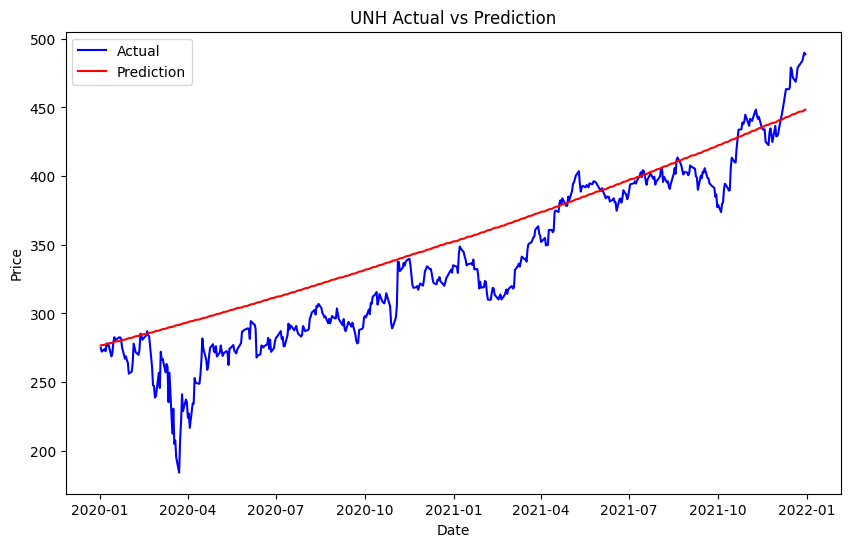

In [12]:
# Plot dei risultati
rand_ticker = random.choice(tickers)
plt.figure(figsize=(10, 6))
plt.plot(act_adj_close_df[all_split:].index, act_adj_close_df[all_split:][rand_ticker], label='Actual', color='blue')
plt.plot(ARIMA_prediction_df.index, ARIMA_prediction_df[rand_ticker], label='Prediction', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{rand_ticker} Actual vs Prediction')
plt.legend()
plt.show()


In [13]:
# valutazione del modello ARIMA (previsione a lungo termine)
for ticker in tickers:
    ARIMA_model_perf_df[ticker] = [MAE(act_adj_close_df[ticker][all_split:], ARIMA_prediction_df[ticker]), MSE(act_adj_close_df[ticker][all_split:], ARIMA_prediction_df[ticker]),
                                   RMSE(act_adj_close_df[ticker][all_split:], ARIMA_prediction_df[ticker]), MAPE(act_adj_close_df[ticker][all_split:], ARIMA_prediction_df[ticker])]

In [14]:
# stampo i risultati della valutazione
ARIMA_model_perf_df

,AAPL,MSFT,CSCO,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ
MAE,26.069563,45.070775,5.464753,29.426472,3.440962e+04,69.610389,27.764117,22.425004,22.574049,5.386460
MSE,889.897662,2975.142707,45.666194,1085.128035,2.021104e+09,7897.297818,1090.226947,828.334083,785.058747,48.790536
RMSE,29.831153,54.544869,6.757677,32.941282,4.495669e+04,88.866742,33.018585,28.780794,28.018900,6.985022
MAPE,0.207782,0.179000,0.122799,0.186742,1.112229e-01,0.400838,0.137771,0.235576,0.075282,0.039505


In [15]:
# perdita del modello durante il training
ARIMA_model_loss_df

,AAPL,MSFT,CSCO,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ
MAE,0.235635,0.202563,0.126073,0.212126,0.101403,0.556984,0.126349,0.195871,0.070800,0.038363
MSE,0.067314,0.053020,0.023523,0.056243,0.019095,0.401514,0.021689,0.068988,0.008750,0.002677
RMSE,0.259449,0.230260,0.153372,0.237156,0.138184,0.633651,0.147271,0.262657,0.093541,0.051735
MAPE,0.049007,0.036758,0.033300,0.041993,0.008024,0.109210,0.023848,0.043106,0.012453,0.007814


### 3. Modello ARIMA one-step

In [16]:
# creazione dei dataframe dei risultati
ARIMA_onestep_prediction_df = pd.DataFrame(index=df.index[all_split:], columns=tickers)
ARIMA_onestep_model_perf_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE'], columns=tickers)
ARIMA_onestep_model_loss_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE'], columns=tickers)

In [17]:
# previsione one-step(viene valutato un giorno alla volta) su ogni ticker
for ticker in tickers:
    train_data, test_data = act_adj_close_sq_df[ticker][:all_split], act_adj_close_sq_df[ticker][all_split:]

     # fitting model
    print('----------')
    print(f'{ticker} fitting...')
    print(f'{len(tickers) - (tickers.index(ticker) + 1)} left')

    model_one_step = create_model_auto_arima(train_set=train_data)

    history = [x for x in train_data.values]

    model_predictions = []

    for time_point in list(test_data.index):
        model_one_step.fit(history)
        output = model_one_step.predict(n_periods=1)
        yhat = output[0]
        model_predictions.append(yhat)
        true_test_value = test_data.loc[time_point]
        print(time_point)
        history.append(true_test_value)
    ARIMA_onestep_prediction_df[ticker] = model_predictions
    ARIMA_onestep_model_loss_df[ticker] = [MAE(test_data, model_predictions), MSE(test_data, model_predictions), RMSE(test_data, model_predictions), 
                                           MAPE(test_data, model_predictions)]

----------
AAPL fitting...
9 left
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13590.207, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13588.914, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13588.933, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13583.416, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13586.638, Time=0.47 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.204 seconds
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-13 00:00:00
2020-01-14 00:00:00
2020-01-15 00:00:00
2020-01-16 00:00:00
2020-01-17 00:00:00
2020-01-21 00:00:00
2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-27 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00
2020-01-30 00:00:00
2020-01-31 00:00:00
2020-02-03 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00
2020-02-06 00:00:00
2020-0

In [18]:
# riporto i dati nella loro forma originale
ARIMA_onestep_prediction_df = np.exp(ARIMA_onestep_prediction_df)

In [19]:
# stampo gli ultimi valori predetti 
ARIMA_onestep_prediction_df.tail()

,AAPL,MSFT,CSCO,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ
Date,,,,,,,,,,
2021-12-23,173.624712,326.248227,56.970772,171.220669,444541.414971,293.993184,214.203619,145.889614,479.229588,157.618104
2021-12-27,174.257513,328.254713,57.665203,171.252147,444857.305556,296.393807,213.256549,146.277586,480.442070,157.981808
2021-12-28,178.262336,335.008110,58.720726,169.851112,447025.698718,309.447837,213.951839,147.144765,484.439029,159.228967
2021-12-29,177.233838,335.070438,58.822575,170.843952,449448.287773,303.215693,214.461667,147.620456,487.776258,159.950367
2021-12-30,177.322765,335.397310,59.220718,169.381853,451967.689126,300.004525,214.602845,147.589204,490.337401,161.026386


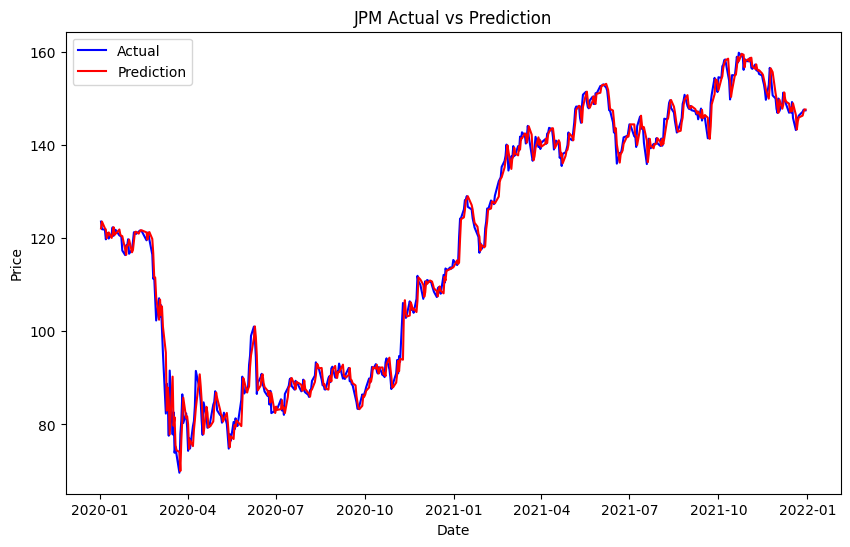

In [20]:
# Plot dei risultati
rand_ticker = random.choice(tickers)
plt.figure(figsize=(10, 6))
plt.plot(act_adj_close_df[all_split:].index, act_adj_close_df[all_split:][rand_ticker], label='Actual', color='blue')
plt.plot(ARIMA_onestep_prediction_df.index, ARIMA_onestep_prediction_df[rand_ticker], label='Prediction', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{rand_ticker} Actual vs Prediction')
plt.legend()
plt.show()

In [21]:
# valutazione del modello ARIMA (previsione one-step)
for ticker in tickers:
    ARIMA_onestep_model_perf_df[ticker] = [MAE(act_adj_close_df[ticker][all_split:], ARIMA_onestep_prediction_df[ticker]), MSE(act_adj_close_df[ticker][all_split:], ARIMA_onestep_prediction_df[ticker]),
                                   RMSE(act_adj_close_df[ticker][all_split:], ARIMA_onestep_prediction_df[ticker]), MAPE(act_adj_close_df[ticker][all_split:], ARIMA_onestep_prediction_df[ticker])]

In [22]:
# stampo i risultati della valutazione
ARIMA_onestep_model_perf_df

,AAPL,MSFT,CSCO,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ
MAE,1.749295,2.962123,0.531680,2.126793,3.533315e+03,3.293253,2.779932,1.778578,4.273377,1.279440
MSE,5.623259,16.487588,0.618217,8.275062,2.493223e+07,24.138679,15.541391,6.203025,40.136452,3.598762
RMSE,2.371341,4.060491,0.786268,2.876641,4.993219e+03,4.913113,3.942257,2.490587,6.335334,1.897040
MAPE,0.016306,0.014143,0.012985,0.014657,1.046942e-02,0.023569,0.014388,0.016578,0.013977,0.009385


In [23]:
# perdita del modello durante il training
ARIMA_onestep_model_loss_df

,AAPL,MSFT,CSCO,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ
MAE,0.016301,0.014134,0.012977,0.014655,0.010457,0.023578,0.014357,0.016567,0.013962,0.009381
MSE,0.000558,0.000451,0.000423,0.000409,0.000253,0.001069,0.000468,0.000653,0.000535,0.000221
RMSE,0.023617,0.021232,0.020570,0.020227,0.015895,0.032693,0.021628,0.025559,0.023140,0.014857
MAPE,0.003537,0.002665,0.003515,0.002964,0.000823,0.004962,0.002733,0.003575,0.002453,0.001912


In [24]:
# trasformo il dataframe dei prezzi delle azione di ogni giorno nella differenza tra il giorno stesso e il giorno precedente
ARIMA_pred_daily_ret_df = ARIMA_onestep_prediction_df.pct_change()  # calcolo la differenza ripetto al giorno precedente
ARIMA_pred_daily_ret_df = ARIMA_pred_daily_ret_df.iloc[1:, :]
ARIMA_pred_daily_ret_df.head()

,AAPL,MSFT,CSCO,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ
Date,,,,,,,,,,
2020-01-03,0.022825,0.017830,0.017013,0.027161,0.007281,0.019600,0.015657,0.011968,-0.005037,0.000558
2020-01-06,-0.009726,-0.011712,-0.016315,-0.012144,-0.007409,-0.016013,-0.006746,-0.011593,-0.010124,-0.011149
2020-01-07,0.007971,0.002422,0.003569,0.014891,0.002024,0.004195,-0.001953,-0.002300,0.006944,-0.001147
2020-01-08,-0.004705,-0.008786,-0.006485,0.002092,-0.003246,0.012111,-0.002485,-0.015343,-0.006039,0.005593
2020-01-09,0.016092,0.015197,0.000632,-0.007812,0.000424,0.001876,0.015581,0.005477,0.021092,-0.000206


### 4. Modello LSTM

In [25]:
# creazione del dataset per il train
def dataset_train_creation(train_data, time_steps):
    x_data = []
    y_data = []
    for i in range(time_steps, len(train_data)):
        x_data.append(train_data[i - time_steps: i, 0])
        y_data.append(train_data[i, 0])
    return np.array(x_data), np.array(y_data)

In [26]:
# creazione del dataset per il test
def dataset_test_creation(total_dataset, time_steps, train_data):
    test_data_adjusted = total_dataset[len(train_data) - time_steps:, :]
    x_data = []
    for i in range(time_steps, len(test_data_adjusted)):
        x_data.append(test_data_adjusted[i - time_steps: i, 0])
    return np.array(x_data)

In [27]:
# creazione del modello LSTM, con 3 livelli
def create_model(time_steps=1, neurons=100, activation='relu', optimizer='adam', dropout_rate=0.0):
    model = Sequential(name="RNN_model")
    model.add(LSTM(units=neurons, activation=activation, return_sequences=False, input_shape=(time_steps, 1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))

    model.compile(optimizer=optimizer, loss='mse', metrics=[k.metrics.MeanAbsoluteError(), k.metrics.RootMeanSquaredError(), k.metrics.MeanAbsolutePercentageError()])

    return model

In [28]:
# creazione dei dataframe dei risultati 
LSTM_prediction_df = pd.DataFrame(index=df.index[all_split:], columns=tickers)
LSTM_model_perf_df = pd.DataFrame(index=['MSE','MAE', 'RMSE', 'MAPE'], columns=tickers)
LSTM_model_loss_df = pd.DataFrame(index=['MSE','MAE', 'RMSE', 'MAPE'], columns=tickers)

In [29]:
# normalizzazione dell'intero insieme dei dati
scaler = MinMaxScaler(feature_range=(0,1))

# previsione LSTM fatta su ogni ticker
for ticker in tickers:
    data_scaled = scaler.fit_transform(np.array(act_adj_close_df[ticker]).reshape(-1, 1))   # normalizzo i dati 

    train, test = data_scaled[:all_split], data_scaled[all_split:]                          # divido in train set e test set 

    train_data = data_scaled[0: len(train), :]
    test_data = data_scaled[len(train): len(data_scaled), :]

    time_steps = 1

    x_train, y_train = dataset_train_creation(train_data=train_data, time_steps=time_steps)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    x_test = dataset_test_creation(total_dataset=data_scaled, time_steps=time_steps, train_data=train_data)
    y_test = np.array(test_data)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    # fitting model
    print('----------')
    print(f'{ticker} fitting...')
    print(f'{len(tickers) - (tickers.index(ticker) + 1)} left')

    model = create_model(time_steps=time_steps)

    model.summary()

    model.fit(x_train, y_train,
              epochs=200,
              batch_size=24,
              shuffle=False,
              validation_split=0.2,
              verbose=0)    


    scaled_preds = model.predict(x_test)
    test_preds = scaler.inverse_transform(scaled_preds)
    LSTM_prediction_df[ticker] = test_preds
    score = model.evaluate(x_test, y_test, verbose=0) 
    LSTM_model_loss_df[ticker] = [score[0], score[1], score[2], score[3]]
   
    


----------
AAPL fitting...
9 left
Model: "RNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
16/16 [==============================] - 0s 1ms/step
----------
MSFT fitting...
8 left
Model: "RNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)     

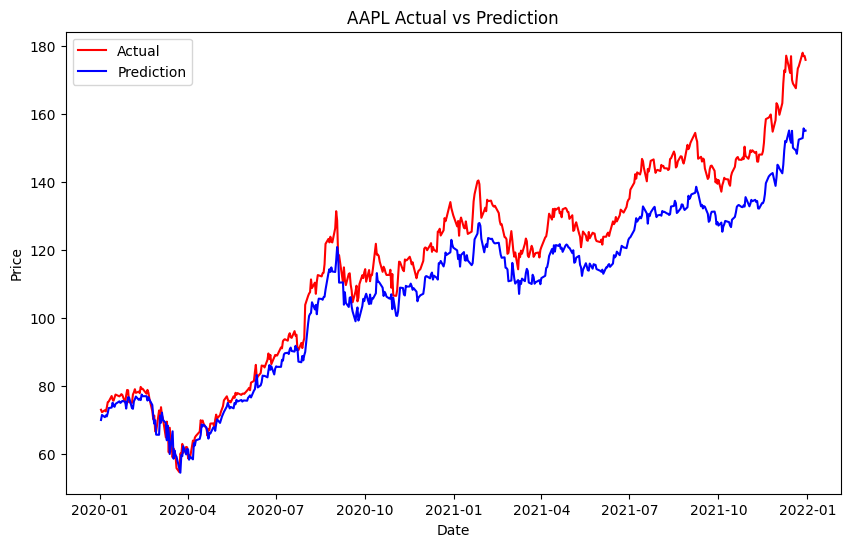

In [30]:
# Plot dei risultati 
rand_ticker = random.choice(tickers)
plt.figure(figsize=(10, 6))
plt.plot(act_adj_close_df.index[all_split:], act_adj_close_df[rand_ticker][all_split:], label='Actual', color='red')
plt.plot(LSTM_prediction_df.index, LSTM_prediction_df[rand_ticker], label='Prediction', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{rand_ticker} Actual vs Prediction')
plt.legend()
plt.show()

In [31]:
# valutazione del modello LSTM
for ticker in tickers: 
    LSTM_model_perf_df[ticker] = [MAE(act_adj_close_df[ticker][all_split:], LSTM_prediction_df[ticker]), MSE(act_adj_close_df[ticker][all_split:], LSTM_prediction_df[ticker]), 
                                  RMSE(act_adj_close_df[ticker][all_split:], LSTM_prediction_df[ticker]), MAPE(act_adj_close_df[ticker][all_split:], LSTM_prediction_df[ticker])]

In [32]:
# stampo i risultati della valutazione
LSTM_model_perf_df

,AAPL,MSFT,CSCO,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ
MSE,8.643540,3.703939,1.534679,3.109986,5.026958e+03,6.722846,3.284653,2.110360,7.746086,3.401381
MAE,102.808580,22.446511,3.605063,15.391743,4.252191e+07,86.513593,20.029759,7.825587,97.358045,15.898946
RMSE,10.139457,4.737775,1.898700,3.923231,6.520882e+03,9.301268,4.475462,2.797425,9.867018,3.987348
MAPE,0.068175,0.017121,0.033659,0.020610,1.403886e-02,0.042813,0.016813,0.018946,0.022656,0.023348


In [33]:
# perdita del modello durante il training
LSTM_model_loss_df

,AAPL,MSFT,CSCO,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ
MSE,0.003465,0.000221,0.001451,0.000469,0.000334,0.000789,0.000375,0.000401,0.000446,0.000968
MAE,0.050178,0.011621,0.030791,0.017169,0.014079,0.020298,0.014219,0.015101,0.016579,0.026547
RMSE,0.058862,0.014864,0.038095,0.021659,0.018263,0.028083,0.019374,0.020018,0.021119,0.031120
MAPE,7.166236,1.875081,4.277143,2.141583,1.968537,4.352394,1.822490,2.353460,2.436339,3.181877


In [34]:
# trasformo il dataframe dei prezzi delle azione di ogni giorno nella differenza tra il giorno stesso e il giorno precedente
LSTM_pred_daily_ret_df = LSTM_prediction_df.pct_change()  # calcolo la differenza ripetto al giorno precedente
LSTM_pred_daily_ret_df = LSTM_pred_daily_ret_df.iloc[1:, :]
LSTM_pred_daily_ret_df.head()

,AAPL,MSFT,CSCO,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ
Date,,,,,,,,,,
2020-01-03,0.021034,0.018240,0.018744,0.027137,0.007516,0.021048,0.017374,0.011689,-0.004843,0.000604
2020-01-06,-0.008969,-0.012270,-0.017947,-0.012140,-0.008676,-0.017172,-0.008063,-0.012730,-0.009736,-0.010218
2020-01-07,0.007347,0.002547,0.003921,0.014889,0.002974,0.004504,-0.002191,-0.000767,0.006677,-0.001102
2020-01-08,-0.004338,-0.008983,-0.007118,0.002093,-0.003679,0.013000,-0.002678,-0.016415,-0.005807,0.005389
2020-01-09,0.014819,0.015691,0.000693,-0.007814,0.000810,0.002013,0.017357,0.007530,0.020271,-0.000122


### 5. Confronto modelli

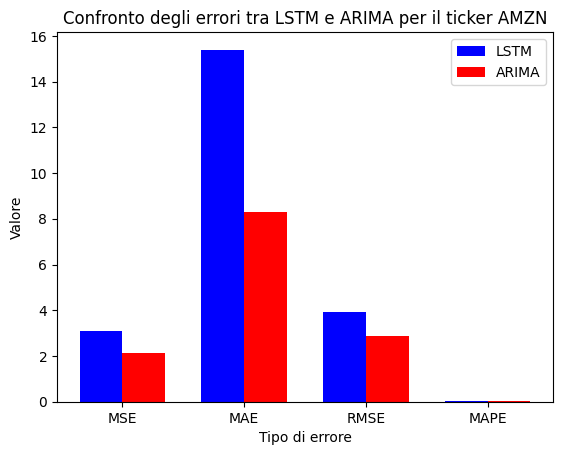

In [35]:
# creazione dell'istogramma per confrontare gli errori dei due modelli ARIMA one-step e LSTM
rand_ticker = random.choice(tickers)                    # scelgo un ticker casuale
bar_width = 0.35                                        # larghezza delle barre
index = np.arange(len(LSTM_model_perf_df.index))        # Posizioni delle barre


plt.bar(index, LSTM_model_perf_df[rand_ticker], bar_width, label='LSTM', color='blue')
plt.bar(index + bar_width, ARIMA_onestep_model_perf_df[rand_ticker], bar_width, label='ARIMA', color='red')
plt.xlabel('Tipo di errore')
plt.ylabel('Valore')
plt.title('Confronto degli errori tra LSTM e ARIMA per il ticker ' + rand_ticker)
plt.xticks(index + bar_width / 2, LSTM_model_perf_df.index)
plt.legend()
plt.show()


### 6. Allocazione portafoglio

<Axes: >

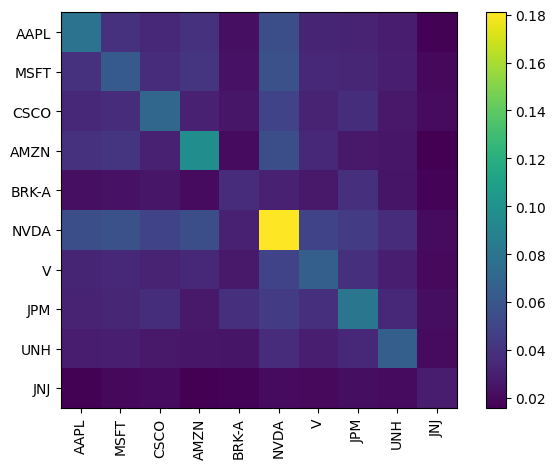

In [36]:
# calcolo matrice di covarianza su dati storici
S = CovarianceShrinkage(act_adj_close_df).ledoit_wolf()
plotting.plot_covariance(S)

In [37]:
# calcolo delle performance del portafoglio standard non usando modelli di previsione
mu = expected_returns.mean_historical_return(act_adj_close_df)              # media dei ritorni storici 
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
standard_weights = ef.clean_weights()
print(standard_weights)
print(ef.portfolio_performance(verbose=True))

OrderedDict([('AAPL', 0.29512), ('MSFT', 0.0), ('CSCO', 0.0), ('AMZN', 0.18687), ('BRK-A', 0.0), ('NVDA', 0.14224), ('V', 0.0), ('JPM', 0.0), ('UNH', 0.37577), ('JNJ', 0.0)])
Expected annual return: 31.8%
Annual volatility: 22.2%
Sharpe Ratio: 1.35
(0.3184326342728487, 0.22150695109867252, 1.347283382271416)


In [38]:
# trasformo il dataframe dei prezzi delle azione di ogni giorno nella differenza tra il giorno stesso e il giorno precedente
act_adj_close_val_df = act_adj_close_df.iloc[time_step + 1 + all_split:, :]
act_daily_ret_df = act_adj_close_val_df.pct_change()
act_daily_ret_df = act_daily_ret_df.iloc[1:, :]

In [39]:
# dataframe inserire i rendimenti di vari portafogli 
daily_port_ret_df = act_daily_ret_df.copy()
daily_port_ret_df.drop(columns=tickers, inplace=True)

In [40]:
# risk free return, usato per calcolare sharpe ratio
risk_free_ret = 0.015

In [41]:
# funzione per calcolare i rendimenti dei portafogli (in base alla differenza dei pesi)
def add_portfolio(portfolio, weights):
    daily_port_ret_df[f'{portfolio} Return'] = act_daily_ret_df.dot(weights)
    daily_port_ret_df[f'{portfolio} Cum Prod Return'] = (1 + daily_port_ret_df[f'{portfolio} Return']).cumprod()

    print(portfolio)
    print('Weights:')
    print(weights)
   

In [42]:
# calcolo i rendimenti del portafoglio standard con i pesi calcolati per massimizzare lo sharpe ratio
# usando funzioni messe a disposizione dalla libreria pyportfolioopt (per il calcolo usano valori storici dei prezzi)
add_portfolio('St', np.array(list(standard_weights.values())))

St
Weights:
[0.29512 0.      0.      0.18687 0.      0.14224 0.      0.      0.37577
 0.     ]


In [43]:
# calcolo i pesi in modo che sia uguale per ogni azione
n_assets = len(tickers)
eq_weights = np.ones(n_assets) / n_assets

In [44]:
# calcolo i rendimenti del portafoglio con i pesi equivalenti 
add_portfolio('Eq', eq_weights)

Eq
Weights:
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


C:\Users\fanta\AppData\Local\Temp\ipykernel_19936\3231047092.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5, 1, 0), color='r', s=1000)
C:\Users\fanta\AppData\Local\Temp\ipykernel_19936\3231047092.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(min_vol_port[1], min_vol_port[0], marker=(5, 1, 0), color='g', s=1000)


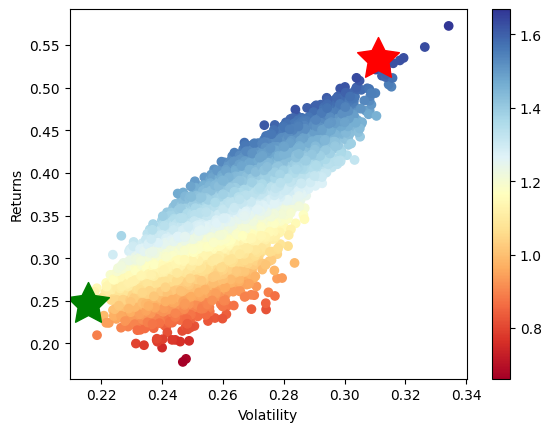

In [45]:
# Calcolo della media e la covarianza dei redimenti giornalieri
mean_daily_returns = ARIMA_pred_daily_ret_df.mean()
cov_matrix = ARIMA_pred_daily_ret_df.cov()

# Imposta il numero di simulazioni
num_portfolios = 25000
# Imposta un array dei risultati
results = np.zeros((len(tickers)+3, num_portfolios))

for i in range(num_portfolios):
    # Selezioni di pesi random
    weights = np.array(np.random.random(len(tickers)))

    # Ribilanciamento dei pesi per avere somma 1
    weights /= np.sum(weights)

    # Calcolo dei rendimenti e volatilità del portafoglio
    portfolio_return = np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

    # Memorizzazioni nell'array dei risultati
    results[0, i] = portfolio_return
    results[1, i] = portfolio_std_dev
    # Memorizzazione dello Sharpe Ratio - elemento risk free escluso per semplicità
    results[2, i] = (results[0, i] - risk_free_ret) / results[1, i]

    # ciclo sul vettore dei pesi e aggiunta dei dati sull'array dei risultati
    for j in range(len(weights)):
        results[j + 3, i] = weights[j]

# Converte l'array dei risultati in un dataframe pandas
results_frame = pd.DataFrame(results.T, columns=['ret', 'stdev', 'sharpe', tickers[0], tickers[1], tickers[2], tickers[3], tickers[4], tickers[5], tickers[6], tickers[7], tickers[8], tickers[9]])
# Individua il portafoglio con il Sharpe Ratio maggiore
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
# Individua il portafoglio con la deviazione standard minima
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
# Crea il grafico scatter colorato dallo Sharpe Ratio
plt.scatter(results_frame.stdev, results_frame.ret, c=results_frame.sharpe, cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
# Visualizza una stella rossa per evidenziare il portafoglio con lo Sharpe Ratio maggiore
plt.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5, 1, 0), color='r', s=1000)
# Visualizza una stella verde per evidenziare il portafoglio con la varianza minima
plt.scatter(min_vol_port[1], min_vol_port[0], marker=(5, 1, 0), color='g', s=1000)

plt.show()

In [46]:
# portafoglio ottimale secondo previsioni del modello ARIMA one-step (migliore tra quelli visti)
max_sharpe_port

ret       0.533773
stdev     0.310844
sharpe    1.668918
AAPL      0.087764
MSFT      0.246983
CSCO      0.001639
AMZN      0.102385
BRK-A     0.002165
NVDA      0.309334
V         0.011007
JPM       0.045829
UNH       0.054216
JNJ       0.138677
Name: 5183, dtype: float64

In [47]:
# pesi del portafoglio con sharpe ratio maggiore secondo ARIMA one-step
max_weigths = max_sharpe_port[['AAPL', 'MSFT', 'CSCO', 'AMZN', 'BRK-A', 'NVDA', 'V', 'JPM', 'UNH', 'JNJ']].values

In [48]:
# calcolo i rendimenti del portafoglio con sharpe-ratio maggiore secondo ARIMA one-step
add_portfolio('max_sharpe', max_weigths)

max_sharpe
Weights:
[0.08776368 0.24698302 0.00163934 0.10238463 0.00216529 0.30933386
 0.01100737 0.04582936 0.05421625 0.13867719]


In [49]:
# stampo i rendimenti di tutti i portafogli creati 
daily_port_ret_df

,St Return,St Cum Prod Return,Eq Return,Eq Cum Prod Return,max_sharpe Return,max_sharpe Cum Prod Return
Date,,,,,,
2020-05-29,0.010524,1.010524,0.012118,1.012118,0.019167,1.019167
2020-06-01,0.006044,1.016632,-0.002700,1.009385,-0.001479,1.017660
2020-06-02,0.002243,1.018912,0.006433,1.015879,0.005318,1.023072
2020-06-03,0.000001,1.018913,0.008828,1.024847,0.002145,1.025266
2020-06-04,-0.012814,1.005857,-0.005662,1.019045,-0.007005,1.018084
...,...,...,...,...,...,...
2021-12-23,0.003221,2.031306,0.003066,1.738439,0.004486,2.146693
2021-12-27,0.014640,2.061044,0.013298,1.761557,0.022502,2.194998
2021-12-28,-0.000886,2.059219,-0.000046,1.761475,-0.005897,2.182055


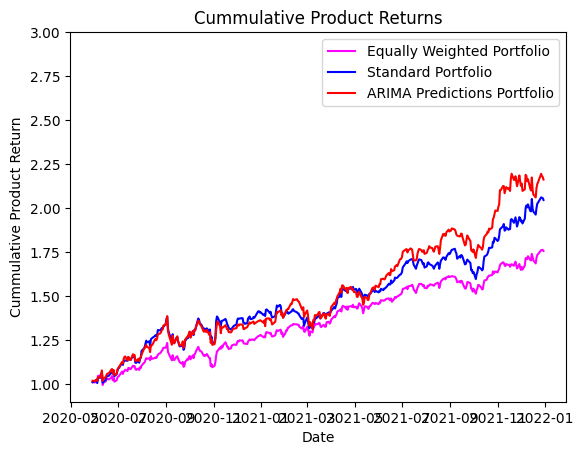

In [50]:
# plot dei portafogli 
plt.plot(daily_port_ret_df.index, daily_port_ret_df['Eq Cum Prod Return'], 
         label='Equally Weighted Portfolio', color='fuchsia')
plt.plot(daily_port_ret_df.index, daily_port_ret_df['St Cum Prod Return'], 
         label='Standard Portfolio', color='blue')
plt.plot(daily_port_ret_df.index, daily_port_ret_df['max_sharpe Cum Prod Return'], 
         label='ARIMA Predictions Portfolio', color='red')
plt.xlabel('Date')
plt.ylabel('Cummulative Product Return')
plt.title('Cummulative Product Returns')
plt.ylim(0.9, 3)
plt.legend()
plt.show()